# Neural Networks For Regression


In this tutorial, we then use neural networks in a regression setting: We are (again) going to predict house prices based on a dataset from a specific town.

As usually, let's start with loading the relevant libaries. We are relying on the keras library, a front-end for tensorflow, tp run the model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz
import pydot
from io import StringIO

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import sklearn.metrics as metrics

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from keras.models import Sequential
from keras.layers import Dense

## Setting and Data

As mentioned, we are going to use a well-known dataset, namely a the House Price Data from Ames, Iowa, which is used in an [ongoing data science competion on kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). It includes 79 features describing details of 1,460 residential homes in Ames, Iowa. We are trying to predict how much a house with given features would be sold for.

### Load the data

We start by loading the data:

In [ ]:
#import pandas as pd
HouseData = pd.read_csv("https://raw.githubusercontent.com/OpenActTextDev/ActuarialRegression/refs/heads/main/CourseCSVData/kc_house_data.csv")
HouseData.head() # check the data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
HouseData.shape

(21613, 21)

It turns out there are many missing variables (NaN), so we need to go though some steps to...

### Prepare the Data

We will follow a relatively simple procedure: We'll check for features with lots of missing values, and then delete these features. We will then just drop the observations with missing features. Of course, more advanced methods such as imputing the missing variables would be possible.

Let's first look for features with missing variables:

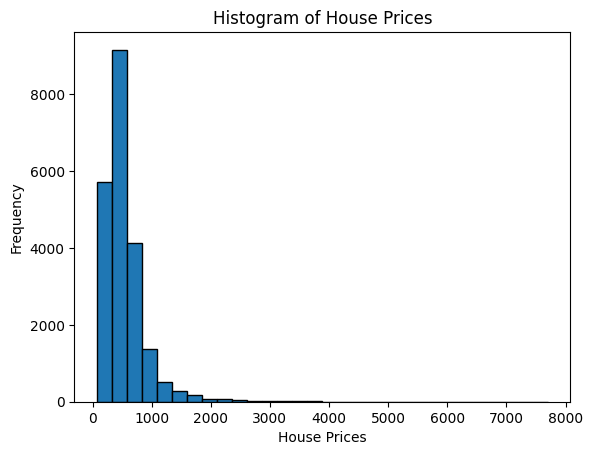

count    21613.000000
mean       540.088142
std        367.127196
min         75.000000
25%        321.950000
50%        450.000000
75%        645.000000
max       7700.000000
Name: price, dtype: float64


In [ ]:
# Define target, sales in thousands
y = HouseData['price']/1000

# Plot histogram
#import matplotlib.pyplot as plt
plt.hist(y, bins=30, edgecolor="black")
plt.xlabel("House Prices")
plt.ylabel("Frequency")
plt.title("Histogram of House Prices")
plt.show()
print(y.describe())

So, let's drop those with lots of missing values:

And let's then drop the observations with missing variables:

In [ ]:
X = HouseData.drop(columns=['price', 'id', 'date', 'zipcode','lat', 'long', 'sqft_living15',
                               'sqft_lot15', 'sqft_basement','view', 'condition','grade'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      21613 non-null  int64  
 1   bathrooms     21613 non-null  float64
 2   sqft_living   21613 non-null  int64  
 3   sqft_lot      21613 non-null  int64  
 4   floors        21613 non-null  float64
 5   waterfront    21613 non-null  int64  
 6   sqft_above    21613 non-null  int64  
 7   yr_built      21613 non-null  int64  
 8   yr_renovated  21613 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 1.5 MB


In [ ]:
X.shape

(21613, 9)

In [ ]:
X.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,sqft_above,yr_built,yr_renovated
count,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,1788.390691,1971.005136,84.402258
std,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,828.090978,29.373411,401.679240
min,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,290.000000,1900.000000,0.000000
25%,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,1190.000000,1951.000000,0.000000
50%,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,1560.000000,1975.000000,0.000000
75%,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,2210.000000,1997.000000,0.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,9410.000000,2015.000000,2015.000000


In [ ]:
X_sc = pd.DataFrame( scale(X) )
X_sc.describe()

,0,1,2,3,4,5,6,7,8
count,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04,2.161300e+04
mean,2.367051e-16,-1.788439e-16,2.419652e-16,1.052023e-17,-3.156068e-17,-5.260114e-18,1.104624e-16,1.914681e-15,1.315028e-18
std,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,-3.624404e+00,-2.745920e+00,-1.948891e+00,-3.521759e-01,-9.154270e-01,-8.717263e-02,-1.809494e+00,-2.417383e+00,-2.101284e-01
25%,-3.987371e-01,-4.736214e-01,-7.108948e-01,-2.430487e-01,-9.154270e-01,-8.717263e-02,-7.226314e-01,-6.810785e-01,-2.101284e-01
50%,-3.987371e-01,1.756067e-01,-1.849914e-01,-1.808075e-01,1.053939e-02,-8.717263e-02,-2.758102e-01,1.360059e-01,-2.101284e-01
75%,6.764851e-01,5.002207e-01,5.118578e-01,-1.066880e-01,9.365058e-01,-8.717263e-02,5.091458e-01,8.849999e-01,-2.101284e-01
max,3.185793e+01,7.641730e+00,1.247807e+01,3.950434e+01,3.714405e+00,1.147149e+01,9.204044e+00,1.497813e+00,4.806428e+00


So we only dropped relatively few observations, which is good!

Next, we will convert the factor variables to dummies and scale the numerical variables:

So, we have the scaled numerical variables, the factor variables as dummies, and then our target variable 'Y'.

Let's now...

### Explore the data

... a bit. I am borrowing this plot from an [article](https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea) I liked:

So, we see that the data is a bit skewed, see the disytribution on the left-hand side. And there are quite a few outliers on the log-scale, meaning there are some very cheap and very expensive homes. This may be a challenge for linear-regression modeling.

We will split the data into *three* parts. One training set consisting of 60% of our data, one validation set we use for tuning models (20%), and finally a test set we use for comparing models (20%):

1. Splits the entire dataset into two parts. Sets aside $20\%$ of the data as the test set.

2. Splits the first $80\%$ of the data (`X_main` and `y_main`)  further into train and validation sets. Sets aside $25\%$ as the validation set

This results in $60:20:20$ three way split. While this is not a strict rule, it is widely used.

In [ ]:
# Thanks https://datascience.stackexchange.com/a/15136
X_main, X_test, y_main, y_test = train_test_split(
    X_sc, y, test_size=0.2, random_state=1
)                                                                   #<1>

# As 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size=0.25, random_state=1
)                                                                   #<2>

X_train.shape, X_val.shape, X_test.shape



NameError: name 'train_test_split' is not defined

## Predictive Modeling

Let's start building and comparing model. As a baseline, let's run a...

###LASSO Regression Model

We use LassoCV for tuning parameter selection:

In [ ]:
lasso_cv = LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, random_state=0) # Increased alphas for wider search
lasso_cv.fit(X_train, y_train)
alpha_optimal = lasso_cv.alpha_

In [ ]:
lasso_model = Lasso(alpha=alpha_optimal)
lasso_model.fit(X_train, y_train)

Lasso(alpha=np.float64(0.07564633275546291))

In [ ]:
y_lasso_pred = lasso_model.predict(X_test)

In [ ]:
y_lasso_pred = pd.DataFrame(lasso_model.predict(X_test))

In [ ]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_lasso_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-y_lasso_pred)/y_lasso_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_lasso_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_lasso_pred))))
## residuals
residuals = y_test - y_lasso_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_idx = max_idx - 1
y_test.info()
y_test[max_idx]
#max_true, max_pred = y_test[max_idx], y_lasso_pred[max_idx]#
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.59
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): nan
Mean Absolute Error (Σ|y-pred|/n): 162
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 264
<class 'pandas.core.series.Series'>
Index: 4323 entries, 15544 to 14200
Series name: price
Non-Null Count  Dtype  
--------------  -----  
4323 non-null   float64
dtypes: float64(1)
memory usage: 196.6 KB
Max Error: 21,608


In [ ]:
print(max_idx)
max_true= y_test[max_idx]
#max_pred =  y_lasso_pred[max_idx]
#max_true, max_pred = y_test[max_idx], y_lasso_pred[max_idx]
#print("Max Error:", "{:,.0f}".format(max_error))

4322


### Random Forest Model

Let's now consider a random forest model. Let's start with a model under default parameters

In [ ]:
house_rf = RandomForestRegressor(random_state=1)
house_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

Let's predict in the test set:

In [ ]:
y_rf_test_pred = house_rf.predict(X_test)

And let's check the performance:

In [ ]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_rf_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-y_rf_test_pred)/y_rf_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_rf_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_rf_test_pred))))
## residuals
residuals = y_test - y_rf_test_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
#max_true, max_pred = y_test[max_idx], y_rf_test_pred[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.65
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.26
Mean Absolute Error (Σ|y-pred|/n): 147
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 244
Max Error: 3,946


So, the performance is similar, and actually a bit worse, than the LASSO regression. We may be able to push performance a bit via tuning, so let's try using a few more trees:

In [ ]:
house_rf = RandomForestRegressor(random_state=1,n_estimators=250)
house_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=250, random_state=1)

In [ ]:
y_rf_test_pred = house_rf.predict(X_test)
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_rf_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-y_rf_test_pred)/y_rf_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_rf_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_rf_test_pred))))
## residuals
residuals = y_test - y_rf_test_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
#max_true, max_pred = y_test[max_idx], y_rf_test_pred[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.67
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.26
Mean Absolute Error (Σ|y-pred|/n): 146
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 240


So, not much better, in line with the point mentioned that random forests aren't super sensitive to tuning.

Let's try...

### Gradient Boosting

Again, let's start with default parameters:

In [ ]:
house_boost = GradientBoostingRegressor(random_state=1)
house_boost.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

And let's predict and check performance:

In [ ]:
y_boost_test_pred = house_boost.predict(X_test)

In [ ]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_boost_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-y_boost_test_pred)/y_boost_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_boost_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_boost_test_pred))))
## residuals
residuals = y_test - y_boost_test_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
#max_true, max_pred = y_test[max_idx], y_boost_test_pred[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.67
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.27
Mean Absolute Error (Σ|y-pred|/n): 150
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 237


So we actually see a bit of a performance increase in terms of MSE. Let's try tuning the model:

In [ ]:
best_rmse = 50000

n_estimators_grid = [100, 500, 1000]
learning_rate_grid = [0.05, 0.075, 0.1]

for n_estimators in n_estimators_grid:
  for learning_rate in learning_rate_grid:
    # Train the GradientBoostingClassifier with the current parameters
    house_boost = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=1)
    house_boost.fit(X_train, y_train)

    # Predict probabilities for the test set
    y_boost_val = house_boost.predict(X_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val, y_boost_val))
    print("RMSE:", rmse)


    # Update the best AUC and parameters if the current AUC is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

print("Best RMSE:", best_rmse)
print("Best parameters:", best_params)

RMSE: 221.10431885850255
RMSE: 217.45659960037835
RMSE: 215.26713009729184
RMSE: 213.44938085296036
RMSE: 214.8149835918918
RMSE: 214.23202759288876
RMSE: 213.61686672961372
RMSE: 217.1995085431727
RMSE: 217.09657289085948
Best RMSE: 213.44938085296036
Best parameters: {'n_estimators': 500, 'learning_rate': 0.05}


So we see something quite curious: It appears the RMSE in the validation set (around 50,000) is much larger than in the test set (around 20,000). This showcases the challenges with using a single split of our data---there may be odd observations that can affect the fit dramatically... So, it is unclear whether the guidance from the tuning exercise is helpful. However, in line with the guidance, let's try a lower learning rate (and a moderate amount more trees):

In [ ]:
house_boost = GradientBoostingRegressor(random_state=1, learning_rate=0.075, n_estimators=500)
house_boost.fit(X_train, y_train)
y_boost_test_pred = house_boost.predict(X_test)

In [ ]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_boost_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-y_boost_test_pred)/y_boost_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_boost_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_boost_test_pred))))
## residuals
residuals = y_test - y_boost_test_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
#max_true, max_pred = y_test[max_idx], y_boost_test_pred[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.68
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.26
Mean Absolute Error (Σ|y-pred|/n): 146
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 235


So, the performance is similar...

Note that for now, we by default considered a quadratic criterion. We can also choose the absolute value:

In [ ]:
house_boost = GradientBoostingRegressor(random_state=1, loss = "absolute_error", learning_rate=0.075, n_estimators=500)
house_boost.fit(X_train, y_train)
y_boost_test_pred = house_boost.predict(X_test)
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, y_boost_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-y_boost_test_pred)/y_boost_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, y_boost_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, y_boost_test_pred))))
## residuals
residuals = y_test - y_boost_test_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
#max_true, max_pred = y_test[max_idx], y_boost_test_pred[max_idx]
#print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.64
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.27
Mean Absolute Error (Σ|y-pred|/n): 146
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 248


So, the performance is fairly similar, but it optimizes the absolute error. In other applications, this can make a substantive difference.

### Deep Learning

Let's try a deep learning model. We go with a two-layered network. The input shape is determined by the feature matrix. And then we go for two layers, one with 50 neurons and one with 25 neurons. Then we use a 'linear' output layer because we have a regression problem:

In [ ]:
model = Sequential()
model.add(Dense(50, input_shape=(9, ), activation='relu', name='dense_1'))
model.add(Dense(25, activation='relu', name='dense_2'))
model.add(Dense(1, activation='linear', name='dense_output'))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#https://keras.io/api/models/model_training_apis/
model.summary();

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 50)             │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,801 (7.04 KB)

 Trainable params: 1,801 (7.04 KB)

 Non-trainable params: 0 (0.00 B)

Let's make the training data floats:

In [ ]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)

NameError: name 'X_train' is not defined

In [ ]:
X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12967 entries, 13610 to 21496
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       12967 non-null  float64
 1   1       12967 non-null  float64
 2   2       12967 non-null  float64
 3   3       12967 non-null  float64
 4   4       12967 non-null  float64
 5   5       12967 non-null  float64
 6   6       12967 non-null  float64
 7   7       12967 non-null  float64
 8   8       12967 non-null  float64
dtypes: float64(9)
memory usage: 1013.0 KB
<class 'pandas.core.series.Series'>
Index: 12967 entries, 13610 to 21496
Series name: price
Non-Null Count  Dtype  
--------------  -----  
12967 non-null  float64
dtypes: float64(1)
memory usage: 202.6 KB


And let's start training, using 25% of the data as validation sample:

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.25, verbose = False)

Let's check how the fit improved:

In [ ]:
plt.plot(range(5, 1001), history.history["loss"][4:])
plt.plot(range(5, 1001), history.history["val_loss"][4:])

plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("MSE");

NameError: name 'plt' is not defined

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

It seems training a bit longer is warranted--the test loss is still not curving back up.

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.25, verbose = False)

Epoch 1/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 45056.2461 - mae: 141.7819 - val_loss: 44748.9062 - val_mae: 145.8148
Epoch 2/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40841.1133 - mae: 137.6637 - val_loss: 45277.1211 - val_mae: 147.2241
Epoch 3/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 41002.7305 - mae: 138.5020 - val_loss: 45107.9219 - val_mae: 147.2897
Epoch 4/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 42074.7344 - mae: 138.9413 - val_loss: 45016.4258 - val_mae: 146.0780
Epoch 5/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40430.8008 - mae: 138.8412 - val_loss: 45210.7109 - val_mae: 146.4390
Epoch 6/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 40531.5352 - mae: 137.7235 - val_loss: 46026.4531 - val_mae: 149.0679
Epoch 7/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 39600.7109 - mae: 137.7346 - val_loss: 45733.8438 - val_mae: 147.2125
Epoch 8/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 41722.8750 - mae: 139.

Let's check again:

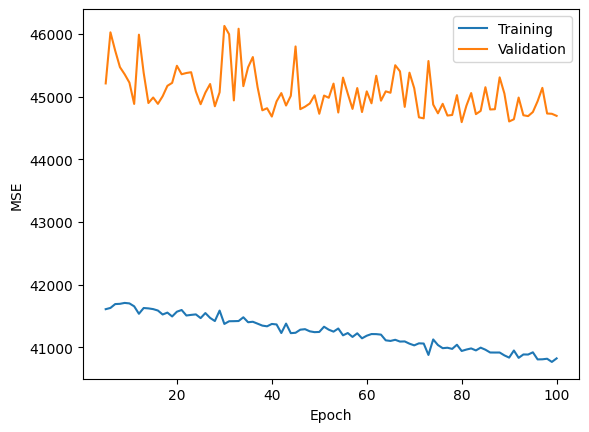

In [ ]:
plt.plot(range(5, 101), history.history["loss"][4:])
plt.plot(range(5, 101), history.history["val_loss"][4:])

plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("MSE");

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

Alright, maybe we could do a bit more training but let's take a look now. Let's check the performance on the test sample:

In [ ]:
0X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [ ]:
house_nn_test_pred = model.predict(X_test)

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
house_nn_test_pred = pd.DataFrame(model.predict(X_test))

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


And let's look at the kpi-s:

In [ ]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, house_nn_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-house_nn_test_pred)/house_nn_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, house_nn_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, house_nn_test_pred))))

R2 (explained variance): 0.69
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): nan
Mean Absolute Error (Σ|y-pred|/n): 148
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 230


So, in the end our model performs ok. But not as well as the boosting model. Likely we could tweak the model more to improve the performance. But getting there takes a patience :-)